# Домашнее задание: Реализация kNN, наивного байесовского классификатора, LDA, QDA

Цель: Реализовать с нуля 4 классификатора, обучить их на датасете, визуализировать результаты, сравнить качество.

Запрещено использовать готовые реализации из sklearn:
   - sklearn.neighbors.KNeighborsClassifier
   - sklearn.naive_bayes.*
   - sklearn.discriminant_analysis.*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from scipy.spatial.distance import cdist
import pandas as pd

sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

data = load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (105, 4), Test size: (45, 4)


In [2]:
import numpy as np

class MyKNNClassifier:
    def __init__(self, k=5, weighted=False, metric='euclidean'):
        self.k = k
        self.weighted = weighted
        self.metric = metric
        self.X_train = None
        self.y_train = None

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _compute_distances(self, X):
        if self.metric == 'euclidean':
            differences = X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]
            squared_diffs = differences ** 2
            sum_squared = np.sum(squared_diffs, axis=-1)
            distances = np.sqrt(sum_squared)
            
        elif self.metric == 'manhattan':
            abs_diffs = np.abs(X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :])
            distances = np.sum(abs_diffs, axis=-1)
            
        elif self.metric == 'chebyshev':
            abs_diffs = np.abs(X[:, np.newaxis, :] - self.X_train[np.newaxis, :, :])
            distances = np.max(abs_diffs, axis=-1)
            
        else:
            raise ValueError(f"No such metric as {self.metric}")

        return distances

    def predict(self, X):
        distances = self._compute_distances(X)
        
        num_samples = X.shape[0]
        indices = np.zeros((num_samples, self.k), dtype=int)
        
        for i in range(num_samples):
            sorted_idx = np.argsort(distances[i])  
            effective_k = min(self.k, len(sorted_idx)) 
            indices[i, :effective_k] = sorted_idx[:effective_k]
        
        neighbors_labels = self.y_train[indices]
        
        predictions = []
        for i in range(num_samples):
            labels = neighbors_labels[i][:np.count_nonzero(indices[i])]
            
            if not self.weighted:
                unique_labels, counts = np.unique(labels, return_counts=True)
                pred_label = unique_labels[np.argmax(counts)] 
            else:
                weights = 1 / (distances[i][indices[i]] + 1e-5) 
                weighted_votes = {}
                for label, weight in zip(labels, weights):
                    if label not in weighted_votes:
                        weighted_votes[label] = 0
                    weighted_votes[label] += weight
                    
                pred_label = max(weighted_votes, key=lambda l: weighted_votes[l]) 
                
            predictions.append(pred_label)
        
        return np.array(predictions)

## Наивный байесовский классификатор (Gaussian Naive Bayes)

Наивный байесовский классификатор основан на **теореме Байеса** и предположении о **условной независимости признаков** относительно класса.

---

### Теорема Байеса:

Вероятность принадлежности объекта к классу $ c $ при наблюдении признакового вектора $ \mathbf{x} = (x_1, x_2, \dots, x_d) $:

$$
P(y = c \mid \mathbf{x}) = \frac{P(\mathbf{x} \mid y = c) \cdot P(y = c)}{P(\mathbf{x})}
$$

Так как $ P(\mathbf{x}) $ одинакова для всех классов, для классификации достаточно максимизировать **числитель** — **апостериорную вероятность**:

$$
\hat{y} = \underset{c}{\mathrm{argmax}} \; P(y = c) \cdot P(\mathbf{x} \mid y = c)
$$

---

### Предположение "наивности":

Признаки условно независимы при заданном классе:

$$
P(\mathbf{x} \mid y = c) = \prod_{j=1}^{d} P(x_j \mid y = c)
$$

Тогда:

$$
\hat{y} = \underset{c}{\mathrm{argmax}} \; P(y = c) \cdot \prod_{j=1}^{d} P(x_j \mid y = c)
$$

---

### Для непрерывных признаков: предположение о нормальном распределении

Часто предполагают, что каждый признак $ x_j $ в классе $ c $ распределён нормально:

$$
x_j \mid y = c \; \sim \; \mathcal{N}(\mu_{jc}, \sigma_{jc}^2)
$$

Тогда:

$$
P(x_j \mid y = c) = \frac{1}{\sqrt{2\pi \sigma_{jc}^2}} \exp\left( -\frac{(x_j - \mu_{jc})^2}{2\sigma_{jc}^2} \right)
$$

---

### Что нужно оценить на обучающей выборке:

- Априорные вероятности:  
  $ \pi_c = \frac{\text{количество объектов класса } c}{\text{общее количество объектов}} $

- Средние:  
  $ \mu_{jc} = \frac{1}{n_c} \sum_{i: y_i = c} x_{ij} $

- Дисперсии:  
  $ \sigma_{jc}^2 = \frac{1}{n_c} \sum_{i: y_i = c} (x_{ij} - \mu_{jc})^2 $

(где $ n_c $ — количество объектов класса $ c $)

---

**Ваша задача**: реализовать этот классификатор с нуля в классе `MyGaussianNB`, используя описанные формулы.

In [3]:
import numpy as np

class MyGaussianNB:
    def __init__(self):
        self.classes = None
        self.mean = None       # среднее по каждому признаку для каждого класса
        self.var = None        # дисперсия по каждому признаку для каждого класса
        self.priors = None     # априорные вероятности классов

    def fit(self, X, y):
        self.classes = np.unique(y)
        n_classes = len(self.classes)
        n_features = X.shape[1]
        
        self.mean = np.zeros((n_classes, n_features))
        self.var = np.zeros((n_classes, n_features))
        self.priors = np.zeros(n_classes)
        
        for i, c in enumerate(self.classes):
            X_c = X[y == c]
            self.mean[i] = np.mean(X_c, axis=0)
            self.var[i] = np.var(X_c, axis=0) + 1e-9 
            self.priors[i] = X_c.shape[0] / X.shape[0]
        
        return self

    def predict(self, X):
        n_samples = X.shape[0]
        n_classes = len(self.classes)
        log_probs = np.zeros((n_samples, n_classes))
        
        for i in range(n_classes):
            variance = self.var[i]
            log_likelihood = -0.5 * np.sum(
                np.log(2 * np.pi * variance) + (X - self.mean[i])**2 / variance,
                axis=1
            )
            log_probs[:, i] = log_likelihood + np.log(self.priors[i])
        
        predictions = np.argmax(log_probs, axis=1)
        
        return self.classes[predictions]

## Линейный (LDA) и квадратичный (QDA) дискриминантный анализ Фишера

LDA и QDA — это **параметрические методы классификации**, основанные на предположении, что признаки в каждом классе распределены **нормально**.

---

### Общая постановка

Пусть дано:
- $ \mathbf{x} \in \mathbb{R}^d $ — вектор признаков,
- $ y \in \{1, 2, \dots, K\} $ — метка класса,
- $ \pi_k = P(y = k) $ — априорная вероятность класса $ k $,
- $ f_k(\mathbf{x}) = P(\mathbf{x} \mid y = k) $ — функция правдоподобия.

Предполагаем, что:
$$
\mathbf{x} \mid y = k \; \sim \; \mathcal{N}(\boldsymbol{\mu}_k, \mathbf{\Sigma}_k)
$$

Тогда:
$$
f_k(\mathbf{x}) = \frac{1}{(2\pi)^{d/2} |\mathbf{\Sigma}_k|^{1/2}} \exp\left( -\frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_k)^\top \mathbf{\Sigma}_k^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) \right)
$$

По теореме Байеса:
$$
P(y = k \mid \mathbf{x}) = \frac{\pi_k f_k(\mathbf{x})}{\sum_{l=1}^K \pi_l f_l(\mathbf{x})}
$$

Классификатор выбирает класс с **максимальной апостериорной вероятностью**:
$$
\hat{y} = \underset{k}{\mathrm{argmax}} \; \pi_k f_k(\mathbf{x})
$$

---

### Переход к дискриминантным функциям

Вместо сравнения вероятностей удобнее сравнивать **логарифмы** (монотонное преобразование):

$$
\delta_k(\mathbf{x}) = \log \left( \pi_k f_k(\mathbf{x}) \right) = \log \pi_k + \log f_k(\mathbf{x})
$$

Подставим выражение для $ f_k(\mathbf{x}) $:

$$
\delta_k(\mathbf{x}) = \log \pi_k - \frac{1}{2} \log |\mathbf{\Sigma}_k| - \frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_k)^\top \mathbf{\Sigma}_k^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) + \text{const}
$$

(где `const` не зависит от $ k $, поэтому его можно игнорировать при сравнении)

---

## Линейный дискриминантный анализ (LDA)

**Предположение**: ковариационные матрицы **одинаковы** для всех классов:

$$
\mathbf{\Sigma}_k = \mathbf{\Sigma} \quad \forall k
$$

Тогда:
- $ \log |\mathbf{\Sigma}_k| $ — константа → исключается,
- $ \mathbf{\Sigma}_k^{-1} = \mathbf{\Sigma}^{-1} $ — общая для всех классов.

Раскрываем квадратичную форму:

$$
(\mathbf{x} - \boldsymbol{\mu}_k)^\top \mathbf{\Sigma}^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) = \mathbf{x}^\top \mathbf{\Sigma}^{-1} \mathbf{x} - 2 \boldsymbol{\mu}_k^\top \mathbf{\Sigma}^{-1} \mathbf{x} + \boldsymbol{\mu}_k^\top \mathbf{\Sigma}^{-1} \boldsymbol{\mu}_k
$$

Первое слагаемое не зависит от $ k $ → исключается.

Остаётся **линейная** дискриминантная функция:

$$
\boxed{
\delta_k^{\text{LDA}}(\mathbf{x}) = \boldsymbol{\mu}_k^\top \mathbf{\Sigma}^{-1} \mathbf{x} - \frac{1}{2} \boldsymbol{\mu}_k^\top \mathbf{\Sigma}^{-1} \boldsymbol{\mu}_k + \log \pi_k
}
$$

Решающие границы — **линейные** (гиперплоскости).

---

## Квадратичный дискриминантный анализ (QDA)

**Предположение**: ковариационные матрицы **разные** для каждого класса: $ \mathbf{\Sigma}_k $.

Тогда дискриминантная функция остаётся **квадратичной**:

$$
\boxed{
\delta_k^{\text{QDA}}(\mathbf{x}) = -\frac{1}{2} \log |\mathbf{\Sigma}_k| - \frac{1}{2} (\mathbf{x} - \boldsymbol{\mu}_k)^\top \mathbf{\Sigma}_k^{-1} (\mathbf{x} - \boldsymbol{\mu}_k) + \log \pi_k
}
$$

Решающие границы — **квадратичные поверхности** (параболы, эллипсы и т.д. в 2D).

---

## Что нужно оценить на обучающей выборке

Для обоих методов:

- **Априорные вероятности**:  
  $ \pi_k = \frac{n_k}{n} $, где $ n_k $ — число объектов класса $ k $

- **Средние векторы**:  
  $ \boldsymbol{\mu}_k = \frac{1}{n_k} \sum_{i: y_i = k} \mathbf{x}_i $

Для **LDA**:
- **Общая ковариационная матрица**:
  $$
  \mathbf{\Sigma} = \frac{1}{n - K} \sum_{k=1}^K \sum_{i: y_i = k} (\mathbf{x}_i - \boldsymbol{\mu}_k)(\mathbf{x}_i - \boldsymbol{\mu}_k)^\top
  $$

Для **QDA**:
- **Ковариационная матрица для каждого класса**:
  $$
  \mathbf{\Sigma}_k = \frac{1}{n_k - 1} \sum_{i: y_i = k} (\mathbf{x}_i - \boldsymbol{\mu}_k)(\mathbf{x}_i - \boldsymbol{\mu}_k)^\top
  $$

---


**Ваша задача**: реализовать оба метода в классе `MyLDAQDA` с параметром `mode='LDA'` или `'QDA'`, используя приведённые формулы.

In [4]:
import numpy as np

class MyLDAQDA:
    def __init__(self, mode='LDA'):
        if mode not in ['LDA', 'QDA']:
            raise ValueError("mode must be either 'LDA' or 'QDA'")
        
        self.mode = mode
        self.classes = None
        self.means = {}
        self.covs = {}         
        self.priors = {}
    
    def fit(self, X, y):
        unique_classes = np.unique(y)
        n_samples, d_features = X.shape
        
        for class_label in unique_classes:
            X_class = X[y == class_label]
            
            self.means[class_label] = np.mean(X_class, axis=0)
            
            self.priors[class_label] = len(X_class) / n_samples
            
            cov_matrix = np.cov(X_class.T)
            self.covs[class_label] = cov_matrix + np.eye(d_features) * 1e-6  
        
        if self.mode == 'LDA':
            total_cov = sum([self.priors[k] * self.covs[k] for k in unique_classes])
            self.covs['common'] = total_cov
    
    def predict(self, X):
        predictions = []
        
        for sample in X:
            max_delta = float('-inf')
            predicted_class = None
            
            for class_label in self.means.keys():
                mu = self.means[class_label]
                
                if self.mode == 'LDA':
                    inv_cov = np.linalg.inv(self.covs['common'])
                    delta = sample @ inv_cov @ mu - 0.5 * mu @ inv_cov @ mu + np.log(self.priors[class_label])
                else:
                    inv_cov = np.linalg.inv(self.covs[class_label])
                    delta = -0.5 * np.log(np.linalg.det(self.covs[class_label])) \
                        - 0.5 * ((sample - mu) @ inv_cov @ (sample - mu)) + np.log(self.priors[class_label])
                
                if delta > max_delta:
                    max_delta = delta
                    predicted_class = class_label
            
            predictions.append(predicted_class)
        
        return np.array(predictions)

## Для метода kNN:
Проведите кросс-валидацию (например, 5-fold) на обучающей выборке для значений k = 1, 2, ..., 30.


Для каждого k посчитайте среднюю Accuracy (долю верных ответов - среднюю по всем классам) по фолдам.


Постройте график: k → accuracy (два графика: обычный и взвешенный kNN).

Выберите k, при котором accuracy максимальна — используйте его для финального тестирования.

In [11]:
import numpy as np

class Metrics():
    def __init__(self, y_test):
        self.y_test = y_test
        self.classes = np.unique(y_test)
        self.classes_ext = self.classes[:, np.newaxis]
        
    def calc_tp(self, predict):
        return np.sum(np.equal(self.y_test, self.classes_ext) & np.equal(predict, self.classes_ext), axis=1)
    
    def calc_fp(self, predict):
        return np.sum(np.equal(self.y_test, self.classes_ext) & ~np.equal(predict, self.classes_ext), axis=1) 
    
    def calc_tn(self, predict):
        return np.sum(~np.equal(self.y_test, self.classes_ext) & ~np.equal(predict, self.classes_ext), axis=1)
    
    def calc_fn(self, predict): 
        return np.sum(~np.equal(self.y_test, self.classes_ext) & np.equal(predict, self.classes_ext), axis=1)
    
    def calc_all(self, predict):
        return self.calc_tp(predict), self.calc_tn(predict), self.calc_fp(predict), self.calc_fn(predict)
    
    def accuracy(self, tp, tn, fp, fn):
        return np.sum((tp + tn) / (tp + tn + fp + fn)) / self.classes.shape[0]
    
    def precision(self, tp, fp):
        return np.sum(tp / (tp + fp)) / self.classes.shape[0]
    
    def recall(self, tp, fn):
        return np.sum(tp / (tp + fn)) / self.classes.shape[0]
    
    def f1(self, tp, fp, fn):
        p, r = self.precision(tp, fp), self.recall(tp, fn)
        return 2 * (p * r) / (p + r)

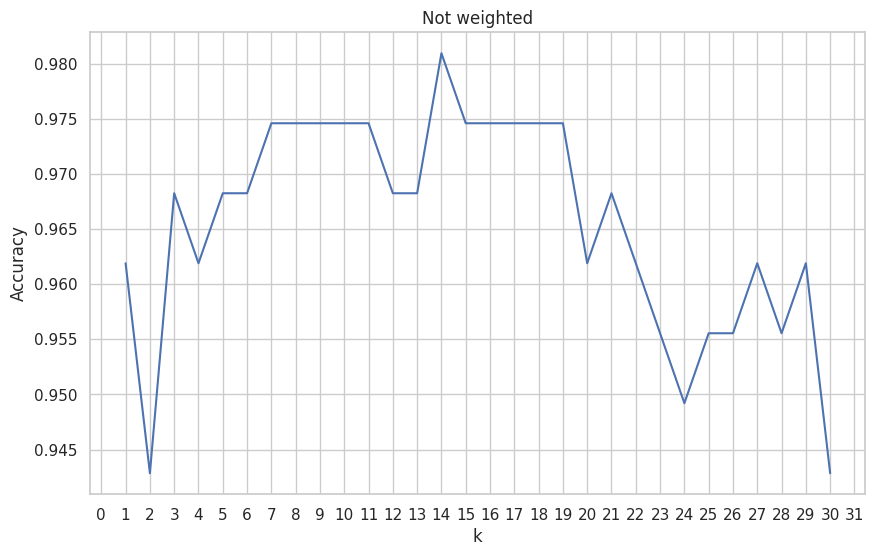

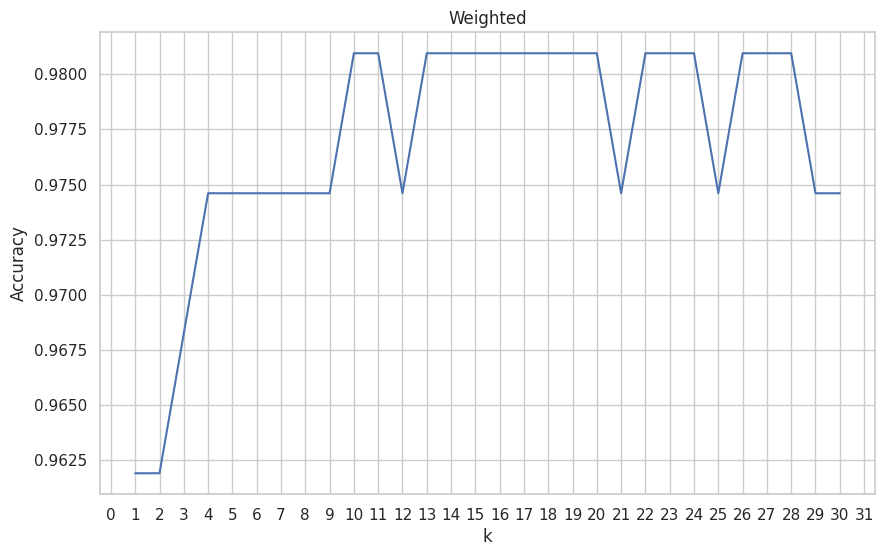

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

X_splitted = np.array_split(X_train, 5)
y_splitted = np.array_split(y_train, 5)

def get_window(X, idx):
    f, l = idx + 1, idx
    return X[:l] + X[f:]

def get_stat(weighted):
    right_perc_arr = []
    for k in range(1,31):
        right_cnt = 0
        for i in range(5):
            cross_X_train = np.concatenate(get_window(X_splitted, i))
            cross_y_train = np.concatenate(get_window(y_splitted, i))
            cross_X_test = X_splitted[i]
            cross_y_test = y_splitted[i]
    
            knn = MyKNNClassifier(k=k, metric='manhattan', weighted=weighted)
            knn.fit(cross_X_train, cross_y_train)
            predict = knn.predict(cross_X_test)

            m = Metrics(cross_y_test)
            tp, tn, fp, fn = m.calc_all(predict)
            right_cnt += m.accuracy(tp, tn, fp, fn)
        right_perc_arr.append(right_cnt / 5)
    return right_perc_arr

def prep_picture(right_perc_arr, title):
    fig, ax = plt.subplots() 
    ax.plot(list(range(1, 31)), right_perc_arr) 
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=1))
    
    ax.set_xlabel("k")
    ax.set_ylabel("Accuracy")
    ax.set_title(title)

prep_picture(get_stat(False), "Not weighted")
prep_picture(get_stat(True), "Weighted")

plt.show()

## Для наивного байесовского классификатора и линейного и квадратичного дискриминантного анализа

Обучите модели на обучающей выборке

In [13]:
nb = MyGaussianNB()
lda = MyLDAQDA()
qda = MyLDAQDA('QDA')

nb.fit(X_train, y_train)
lda.fit(X_train, y_train)
qda.fit(X_train, y_train)

## Для всех моделей

Вызовите методы для предсказания на данных из тестовой выборки

In [15]:
kNN = MyKNNClassifier(k=14, metric='manhattan')
kNNw = MyKNNClassifier(k=14, metric='manhattan', weighted=True)
kNN.fit(X_train, y_train)
kNNw.fit(X_train, y_train)

predict_kNN = kNN.predict(X_test)
predict_kNNw = kNNw.predict(X_test)

predict_nb = nb.predict(X_test)
predict_lda = lda.predict(X_test)
predict_qda = qda.predict(X_test)

## Метрики качества классификации

Для оценки качества классификаторов используются следующие метрики. Обозначения:

- $ TP $ — True Positive (верно предсказанные положительные примеры)
- $ TN $ — True Negative
- $ FP $ — False Positive (ложные срабатывания)
- $ FN $ — False Negative (пропущенные положительные)

Для многоклассовой классификации используется **макро-усреднение** — метрика считается отдельно для каждого класса, затем берётся среднее.

---

### Accuracy (доля правильных ответов)

$$
\text{Accuracy} = \frac{TP + TN}{TP + TN + FP + FN}
$$

---

### Precision (точность — доля верных срабатываний среди всех предсказанных положительных)

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

---

### Recall (полнота — доля найденных положительных среди всех реальных положительных)

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

---

### F1-мера (гармоническое среднее precision и recall)

$$
F1 = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
$$

F1-мера полезна, когда классы несбалансированы — она "наказывает" за сильный дисбаланс между precision и recall.

### Задача:
Для каждой модели подсчитать вышеописанные метрики для каждого из классов и вывести в виде таблицы

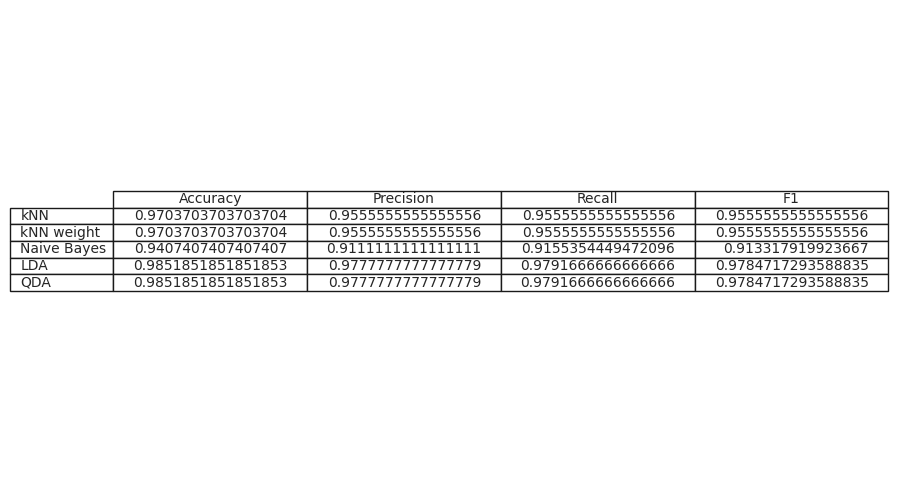

In [24]:
import matplotlib.pyplot as plt

m = Metrics(y_test)
def calc_all_metrics(predict):
    tp, tn, fp, fn = m.calc_all(predict)
    return [m.accuracy(tp, tn, fp, fn), m.precision(tp, fp), m.recall(tp, fn), m.f1(tp, fp, fn)]

data = [calc_all_metrics(x) for x in [predict_kNN, predict_kNNw, predict_nb, predict_lda, predict_qda]]
rows = ['kNN', 'kNN weight', 'Naive Bayes', 'LDA', 'QDA']
columns = ['Accuracy', 'Precision', 'Recall', 'F1']
fig, ax = plt.subplots()
ax.table(cellText=data, colLabels=columns, rowLabels=rows, loc='center')
ax.axis('tight') 
ax.axis('off') 
plt.show()


## Вопросы для подготовки к защите

Что такое kNN? Почему он называется "ленивым" алгоритмом?

Как работает взвешенный kNN? Какие функции весов вы знаете?

Почему в kNN важно нормировать признаки?

Как вы подбирали оптимальное k? Почему не стоит брать k=1 или k=N?

В чём смысл кросс-валидации? Почему нельзя просто выбрать k по максимальной точности на обучающей выборке?

Какие метрики расстояния вы реализовали? Чем отличается Манхэттенское расстояние от Евклидова? Когда какое лучше?

Объясните формулу наивного байесовского классификатора. Почему он "наивный"?

Какие предположения делает Gaussian Naive Bayes?

Чем отличается LDA от QDA? В каких случаях какой метод предпочтительнее?

Почему в LDA решающие границы — линейные, а в QDA — квадратичные? Покажите на формулах.

Запишите формулы для accuracy, precision, recall и F1-score через TP, TN, FP, FN.

Почему accuracy не всегда адекватная метрика? Приведите пример, когда accuracy высокая, но модель бесполезна.

Что такое макро-усреднение (macro-average)? Почему мы его используем в многоклассовой классификации?

В чём разница между macro-F1 и micro-F1? Когда какой предпочтительнее?

Почему F1-мера — это гармоническое среднее, а не арифметическое? Как это влияет на интерпретацию?